In [2]:

import os
from dotenv import load_dotenv
import json
from IPython.display import Image, display
# Load environment variables from the .env file

load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')
# Define the LLM

In [3]:
import json
import time
import uuid
from flask import Flask, request, jsonify
import threading
from langgraph.graph import MessagesState, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.schema import BaseMessage
# Global variable to store human message and diagnostic response
from flask_cors import CORS


import os
from dotenv import load_dotenv

# Load environment variables from the .env file

load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')
# AIConversation class
class AIConversation:
    def __init__(self,id,max_loop) -> None:
        self.model = ChatOpenAI(model="gpt-4o")

        self.config = {"configurable": {"thread_id": str(id)}}
        # Define a new graph
        workflow = StateGraph(MessagesState)

        # Define the three nodes we will cycle between

        # workflow.add_node("start_conversation", self.start_conversation)
        workflow.add_node("identify_issue", self.identify_issues)
        workflow.add_node("question_to_clarify_issue", self.question_to_clarify_issue)
        workflow.add_node("doctor_message", self.doctor_message)
        workflow.add_node("patient_message", self.patient_message)
        workflow.add_node("diagnosis", self.diagnosis)
        workflow.add_node("final_conclusion", self.final_conclusion)
        # Set the entrypoint as `agent`
        # This means that this node is the first one called

        workflow.add_edge(START, "doctor_message")
        workflow.add_edge("doctor_message", "patient_message")
        workflow.add_edge("patient_message", "identify_issue")
        workflow.add_edge("identify_issue", "diagnosis")
        # We now add a conditional edge
        workflow.add_conditional_edges(
            "diagnosis",
            self.should_continue,
            {
                "continue": "question_to_clarify_issue",
                "end": "final_conclusion",
            },
        )
        
        workflow.add_edge("question_to_clarify_issue", "doctor_message")
        workflow.add_edge("final_conclusion", END)

        self.health_issues=None

        self.identify_issues_prompt = PromptTemplate(
            input_variables=["health_issues"],
            template="""
                As an AI assistant, your task is to add new issues into the "health_issues" by reviewing the conversation history mentioned by the human AI. 
                The output will be an updated health issue dictionary. It will contain the duration and severity of the issue. If no duration or severity is mentioned, you can leave the value empty.
                The output MUST be valid JSON. **Do NOT include any additional text outside of the JSON format.**
                Previous_health_issues: {health_issues}
                **The response must strictly follow this structure:**
                {{
                    "issue_name": {{"duration": "Duration of the issue", "severity": "Severity of the issue"}},
                    "issue_name": {{"duration": {{}}, "severity": {{}}}},
                    "issue_name": "... (and so on)"
                }}
                **You will reply only with the JSON itself, and no other descriptive or explanatory text.**
            """
        )


        self.medical_history_prompt = """
        As an AI assistant, your task is to:

        - **Review** the entire conversation history, consider question asked to the patient and their answers.
        - **Objective:** Identify and summarize any **health issues or medical history** mentioned by the human.
        - **Instructions:** Provide a **concise summary** of these health issues in a paragraph.
        - **Important:** If there are no health issues or medical history mentioned, reply with: "No health issues or medical history mentioned."
        """


        self.diagnostic_prompt = PromptTemplate(
            input_variables=["health_issues", "medical_history"],
            template="""
            Imagine you are a doctor, based on the identified health issues and medical history, make a decision on the diagnosis.
            If you are confident of making a final diagnosis, provide the name of the diagnosis, link to ICD-10 code, and rating and justification.
            If you are not confident, provide the name of the diagnosis, link to ICD-10 code, and rating and justification for the diagnosis and the rating.
            The rating should be between 1 to 10, where 1 is the least likely and 10 is the most likely.
            In addition, if you are not confident, clarify what information you need to make a final diagnosis.
            You MUST response "no" if you are not confident to make a final diagnosis, and "yes" if you are confident.
            **You MUST reply ONLY with the JSON itself, and no other descriptive or explanatory text.**

            health_issues: {health_issues}
            medical_history: {medical_history}

            **Example Foramt 1: not confident to make a final diagnosis**
            {{
                "decision":"no",
                "diagnoses": {{
                    "1": {{"name":"Diagnosis 1", "justification": "Explanation of why you think it is likely", "link": "Link to ICD-10 code", "rating": "Rating of Diagnosis 1}},
                    "2": {{"name":"Diagnosis 2", "justification": "Explanation of why you think it is likely", "link": "Link to ICD-10 code", "rating": "Rating of Diagnosis 2}},
                    "3": {{"name":"Diagnosis 3", "justification": "Explanation of why you think it is likely", "link": "Link to ICD-10 code", "rating": "Rating of Diagnosis 3}},
                    }},
                "information_needed": "Information needed to make a final diagnosis"
            }}    

            **Example Format 2: Non-health-related message**

            {{
                "decision":"no",
                "diagnoses": {{}},
                "information_needed": ""
            }}
            **Example Format 3: Confident to make a final diagnosis**
            {{
                "decision":"yes",
                "diagnoses": {{
                    "1": {{"name":"Diagnosis 1", "justification": "Explanation of why you think it is likely", "link": "Link to ICD-10 code", "rating": "Rating of Diagnosis 1}},
                    }},
                "information_needed": ""
            }}
            """
        )    
        self.question_to_clarify_issue_prompt =PromptTemplate(
            input_variables=["health_issues", "medical_history", "required_information"],
            template="""
            As an AI assistant, your task is to:
            Give suggestions on what questions to ask the patient to clarify the health issues or medical history.
            The suggesed questions will address the missing information needed to make a final diagnosis.
            The suggestions should include questions that can help you make a final diagnosis.
            For each suggested question, provide a question and a list of selective answers, this answer should be informative and help you make a final diagnosis.
            The maximum number of questions to ask is 3, while the minimum is 1.
            The maximum number of selective answers for each question is 3, while the minimum is 1.
            The questions should be clear and concise, less than 10 words.


            ### health_issues: {health_issues}
            ### medical_history: {medical_history}
            ### required_information: {required_information}
            **The response must strictly follow this structure:**
            {{
            "question_to_clarify": {{
                "1": {{"question":"first question", "selective_answers": ["answer1", "answer2"]}},
                "2": {{"question":"second question", "selective_answers": ["answer1", "answer2"]}},
                "3": {{"question":"third question", "selective_answers": ["answer1", "answer2"]}}
            }}
            ** Example Format 1: no health issues mentioned **
            {{
            "question_to_clarify": {{
                "1": {{"question":"quation to ask patient potient health issues", "selective_answers": ["issue 1", "issue 2"]}}
                }}
            }}
            **You will reply only with the JSON itself, and no other descriptive or explanatory text.**
            """
        )
        self.final_summary_prompt = PromptTemplate(
            input_variables=["diagnosis", "medical_history"],
            template="""
                Conclude the final diagnosis and provide suggestions. Focus only on the top 1 diagnosis and health history.
                Suggestions may include appropriate treatments and medications.
                Diagnosis: {diagnosis}
                Health history: {medical_history}
                If the diagnosis doesn't make sense, reply with: "I can't help you based on information provided."
                **You will reply only with JSON itself, and no other descriptive or explanatory text.**

                The structure of the response should be:
                {{
                    "final_diagnosis": "Final diagnosis",
                    "justification": "Justification for the diagnosis",
                    "suggestions": "Suggestions for treatment",
                    "medications": "Medications"
                }}  
            """
        )
        self.current_diagnose=""
        self.medical_history=""
        self.questions = {}
        self.health_issues={}
        memory = MemorySaver()
        self.loop_num=0
        self.max_loop=max_loop
        self.app = workflow.compile(checkpointer=memory,interrupt_before=["doctor_message","patient_message"])

    def identify_issues(self,state):
        self.loop_num+=1
        # Format the prompt with input
        formatted_prompt = self.identify_issues_prompt.invoke({"health_issues":self.health_issues})
        # issue_input=self.identify_issues_prompt.invoke(self.health_issues)
        messages = state["messages"]
        messages[0].content=formatted_prompt.text
        health_issues = self.model.invoke(messages)
        self.health_issues=health_issues.content
        # return {"messages": [health_issues]}
    
    def question_to_clarify_issue(self,state):
        if "information_needed" in self.current_diagnose:
            information_needed=json.loads(self.current_diagnose).get("information_needed")
        else:
            information_needed=""
        question_input=self.question_to_clarify_issue_prompt.invoke({"health_issues":self.health_issues,"medical_history":self.medical_history,"required_information":information_needed})
        messages = state["messages"]
        messages[0].content=question_input.text
        self.questions = self.model.invoke(messages).content
        
        # format the questions
        # return {"messages": [questions]}
    
    def should_continue(self,state):
        decision_from_ai=json.loads(self.current_diagnose).get("decision")
        if "yes" in decision_from_ai:
            return "end"
        else:
            return "continue"

    # Define the function that calls the model
    def diagnosis(self, state):
        
        medical_history_input=self.medical_history_prompt
        messages = state["messages"]
        #---- update history
        # print("diag message:",messages)
        messages[0].content = medical_history_input
        # print("history:",messages)
        history = self.model.invoke(messages)
        self.medical_history=history.content
        #---- update history
        formatted_prompt = self.diagnostic_prompt.invoke({"health_issues":self.health_issues,"medical_history":self.medical_history})
        messages[0].content = formatted_prompt.text
        response = self.model.invoke(messages)
        self.current_diagnose = response.content
        # Return the response in the usual format
        # return {"messages": [response]}
    def doctor_message(self,state):
        pass
    def patient_message(self,state):
        pass
    def invoke(self):
        mes={"messages": [{"content": "Start conversation", "role": "system"}]}
        self.app.invoke(mes,config=self.config)
    def final_conclusion(self, state):
        final_input=self.final_summary_prompt.invoke({"diagnosis":self.current_diagnose,"medical_history":self.medical_history})
        final_answer = self.model.invoke(final_input)
        return {"messages": [final_answer]}
# Build the graph


In [4]:
import json
from IPython.display import Image, display

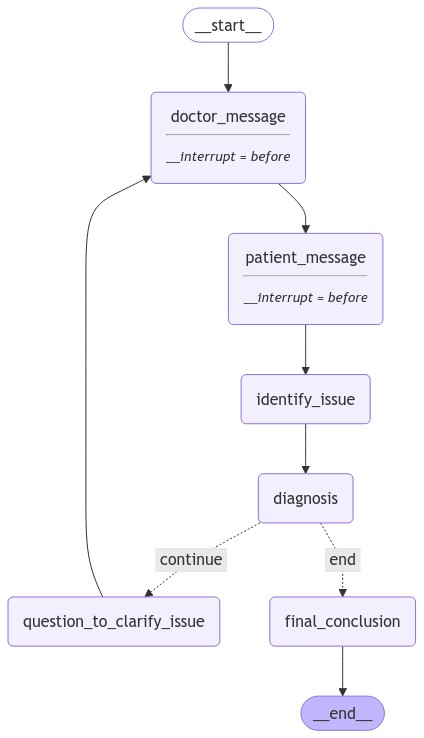

In [5]:
uuid1 = uuid.uuid1()
conv=AIConversation(uuid1, 5)
display(Image(conv.app.get_graph().draw_mermaid_png()))